# Deterministic Uncertainty Estimation (DUE)

## Theoretic Foundation


 DUE builds on DKL by using the same model except for exchanging the feature extractor of the DKL model. With this replacement DUE addresses limitations of DKL and provides potentially robust uncertainty estimates. According to [van Amersfoort, 2021](https://arxiv.org/abs/2102.11409) with DKL, data points dissimilar to the training data (also called OOD data) can potentially be mapped close to feature representations of in-distribution points. These feature representations, which are close in some norm, input into the approximate GP yield similar or nearly the same predictions. This is called "feature collapse", and suggests that a constraint must be placed on the deep feature extractor. Based on deterministic uncertainty quantification (DUQ) [van Amersfoort, 2020](http://proceedings.mlr.press/v119/van-amersfoort20a/van-amersfoort20a.pdf) and spectrally normaplized GPs (SNGP) [Liu, 2020](https://proceedings.neurips.cc/paper/2020/file/543e83748234f7cbab21aa0ade66565f-Paper.pdf), the authors of [van Amersfoort, 2021](https://arxiv.org/abs/2102.11409) propose to use a bi-Lipschitz constraint on a feature extractor.  This bi-Lipschitz constraint is enforced by spectral normalization on the weights, [Miyato, 2018](https://arxiv.org/abs/1802.05957) and [Gouk, 2021](https://link.springer.com/article/10.1007/s10994-020-05929-w).
This constraint migitates so-called "feature collapse", by forcing the feature representation to be sensitive to changes in the input (lower Lipschitz, avoids feature collapse) but also generalize due to smoothness (upper Lipschitz).

For convolutional and linear layers following [van Amersfoort, 2021](https://arxiv.org/abs/2102.11409), we use spectral normalization of the weight matrices to promote approximate bi-Lipschitz continuity. To promote spectral normalization for fully connected layers and $1 \times 1$ convolutions online power iteration are used and for larger convolutions an approximate method, as proposed in [Gouk, 2021](https://link.springer.com/article/10.1007/s10994-020-05929-w) and was first implemented by [Behrmann, 2019](http://proceedings.mlr.press/v97/behrmann19a/behrmann19a.pdf), is used. Spectral normalization is also extended to batch normalization by rescaling the weights, see [van Amersfoort, 2021](https://arxiv.org/abs/2102.11409) for details. 
Adding spectral normalization to batch normalization layers makes it more likely that the entire network's upper Lipschitz constant is bounded. The mean prediction and predictive uncertainty are obtained as for DKL.

*Summary of learnable parameters:*

- weights of DNN feature extractor $\theta$
- for the GP, parameters $\gamma$: noise hyperparamter $\sigma^2$, the GP function mean $m$, the length scale of the GP kernel $l$ and the scale of the kernel $\eta^2$. In the above case the GP hyperparameters are learned by optimizing ELBO.



*Summary of hyperparameters:*

- number of power iterations for spectral normalization, usually set to $r=1$
- number of initial inducing points $M$



## Imports

In [18]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from gpytorch.mlls import VariationalELBO
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import DUEModel, DKLGPLayer
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [19]:
seed_everything(0)  # seed everything for reproducibility

Global seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [20]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). For DUE it is important to use a batch size smaller than the dataset size, so we will choose 50.

In [32]:
dm = ToyHeteroscedasticDatamodule(batch_size=50, n_train=1000)

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

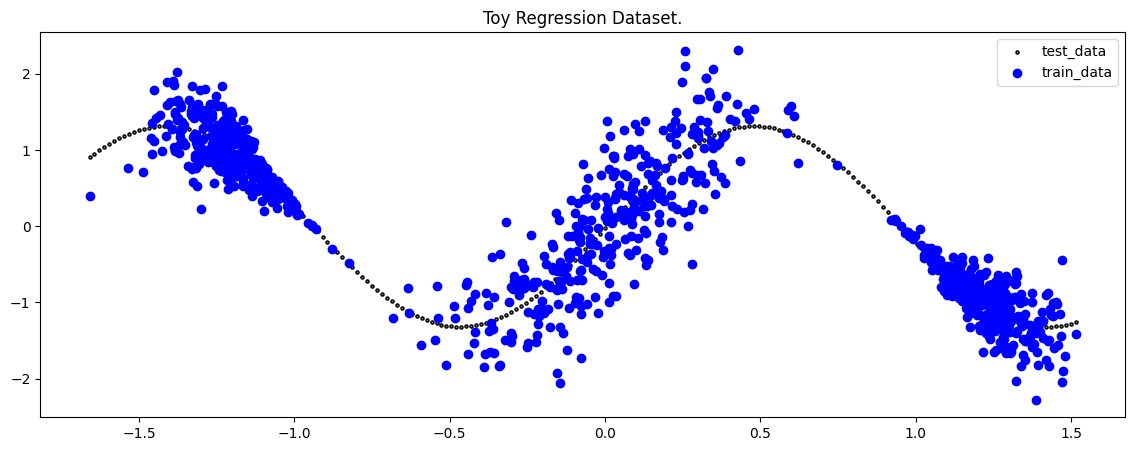

In [33]:
plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP).

In [34]:
feature_extractor = MLP(
    n_inputs=1, n_outputs=10, n_hidden=[100], activation_fn=torch.nn.ReLU()
)
feature_extractor

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [35]:
due_model = DUEModel(
    feature_extractor=feature_extractor,
    gp_layer=partial(DKLGPLayer, n_outputs=1, kernel="RBF"),
    elbo_fn=partial(VariationalELBO),
    optimizer=partial(torch.optim.Adam, lr=2e-3),
    train_loader=train_loader,
    n_inducing_points=50,
    save_dir=my_temp_dir,
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [36]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=500,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    limit_val_batches=0.0,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [37]:
trainer.fit(due_model, dm)  # (uq_method, dm)


  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | MLP                | 1.2 K 
1 | train_metrics     | MetricCollection   | 0     
2 | val_metrics       | MetricCollection   | 0     
3 | test_metrics      | MetricCollection   | 0     
4 | gp_layer          | DKLGPLayer         | 3.1 K 
5 | scale_to_bounds   | ScaleToBounds      | 0     
6 | likelihood        | GaussianLikelihood | 1     
7 | elbo_fn           | VariationalELBO    | 3.1 K 
---------------------------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=500` reached.


## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

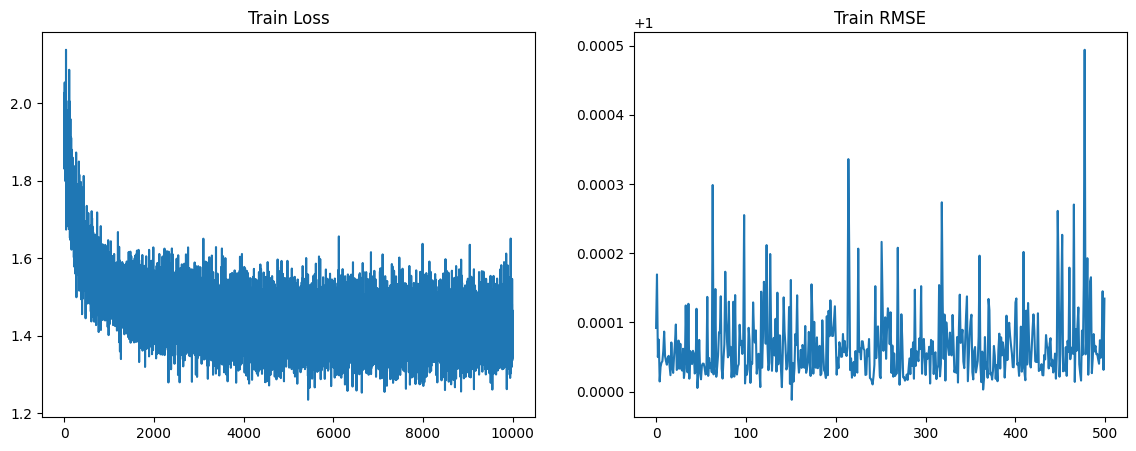

In [38]:
fig = plot_training_metrics(my_temp_dir)

## Prediction

In [39]:
preds = due_model.predict_step(X_test)

## Evaluate Predictions

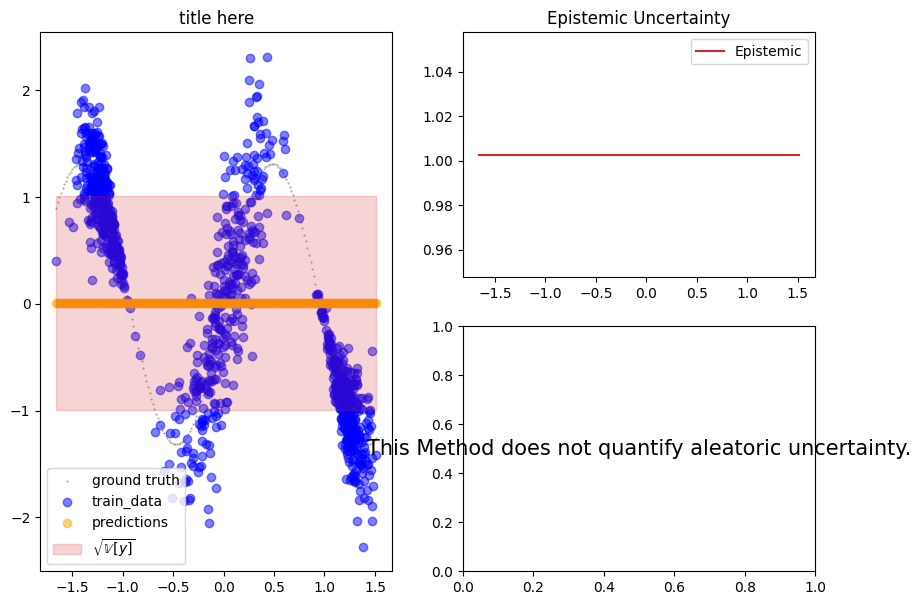

In [41]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["mean"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    title="title here",
    show_bands=False,
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

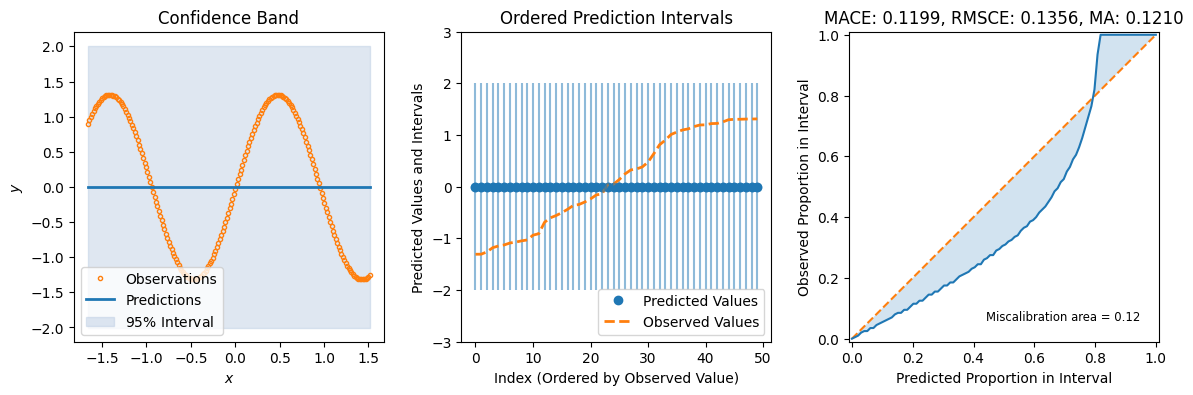

In [42]:
fig = plot_calibration_uq_toolbox(
    preds["mean"], preds["pred_uct"], y_test.cpu().numpy(), X_test.cpu().numpy()
)

## Additional Resources

Links to othere related literature that might be interesting.